In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color
import os
import sys
from safetensors.torch import load_file




In [3]:
sys.path.append('/content/drive/MyDrive/unet_module')

from  dataloader import ADE20KDataset
from   model import UNET

In [4]:
model = UNET()
model.load_state_dict(load_file('/content/drive/MyDrive/unet_module/work_dir/unet_focal/checkpoint 21/model.safetensors'))
path_to_data = '/content/drive/MyDrive/ADE20K'
model = model.to('cuda')

test_data = ADE20KDataset(path_to_data, train=False, inference_mode=True)
test_roots = test_data.file_roots



In [16]:
def inference_image(model, path_to_image, path_to_annotation, colors, image_size=256):
    model.eval()


    resize = transforms.Resize(size=(image_size, image_size))
    normalize = transforms.Normalize(mean=(0.48897059, 0.46548275, 0.4294),
                                     std=(0.22861765, 0.22948039, 0.24054667))
    totensor = transforms.ToTensor()
    topil = transforms.ToPILImage()


    image = Image.open(path_to_image).convert("RGB")
    annot = Image.open(path_to_annotation)
    width, height = annot.size
    annot = np.array(annot) # This goes from 0 to 150 by default


    proc_image = normalize(totensor(resize(image))).unsqueeze(0).to('cuda')


    with torch.no_grad():
        pred = model(proc_image)

        print(f"Max Logit: {pred.max().item()}")
        print(f"Min Logit: {pred.min().item()}")
        print(f"Mean Logit: {pred.mean().item()}")


    pred = pred.argmax(axis=1).cpu().unsqueeze(0)
    pred = F.interpolate(pred.type(torch.FloatTensor), size=(height, width), mode='nearest').squeeze()
    pred = np.array(pred, dtype=np.uint8)


    pred = pred + 1

    ### Overlay Masks on Images ###
    annot_color = color.label2rgb(annot,np.array(image), colors)
    pred_color = color.label2rgb(pred,np.array(image), colors)

    ### Plot Results! ###
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].imshow(annot_color)
    ax[0].set_title("Ground Truth Segmentation")
    ax[0].axis("off")
    ax[1].imshow(pred_color)
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


Max Logit: 342.41619873046875
Min Logit: -194.75257873535156
Mean Logit: 5.974382400512695


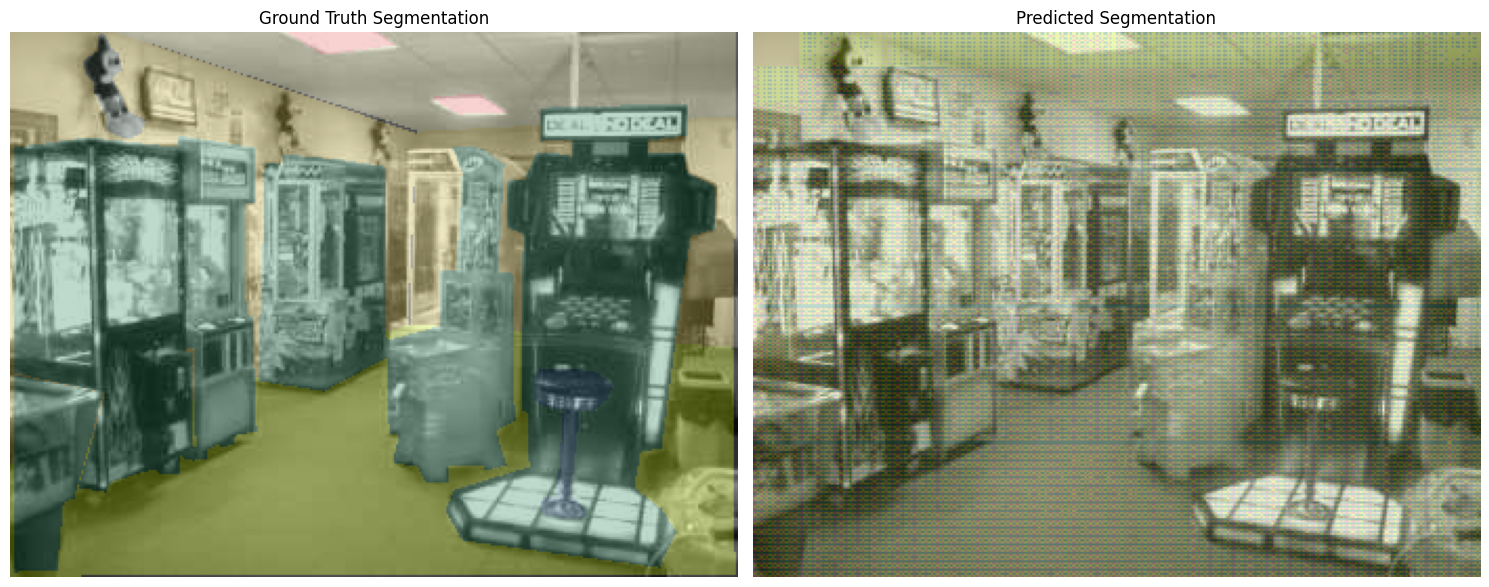

Max Logit: 330.5520935058594
Min Logit: -188.34866333007812
Mean Logit: 6.151785850524902


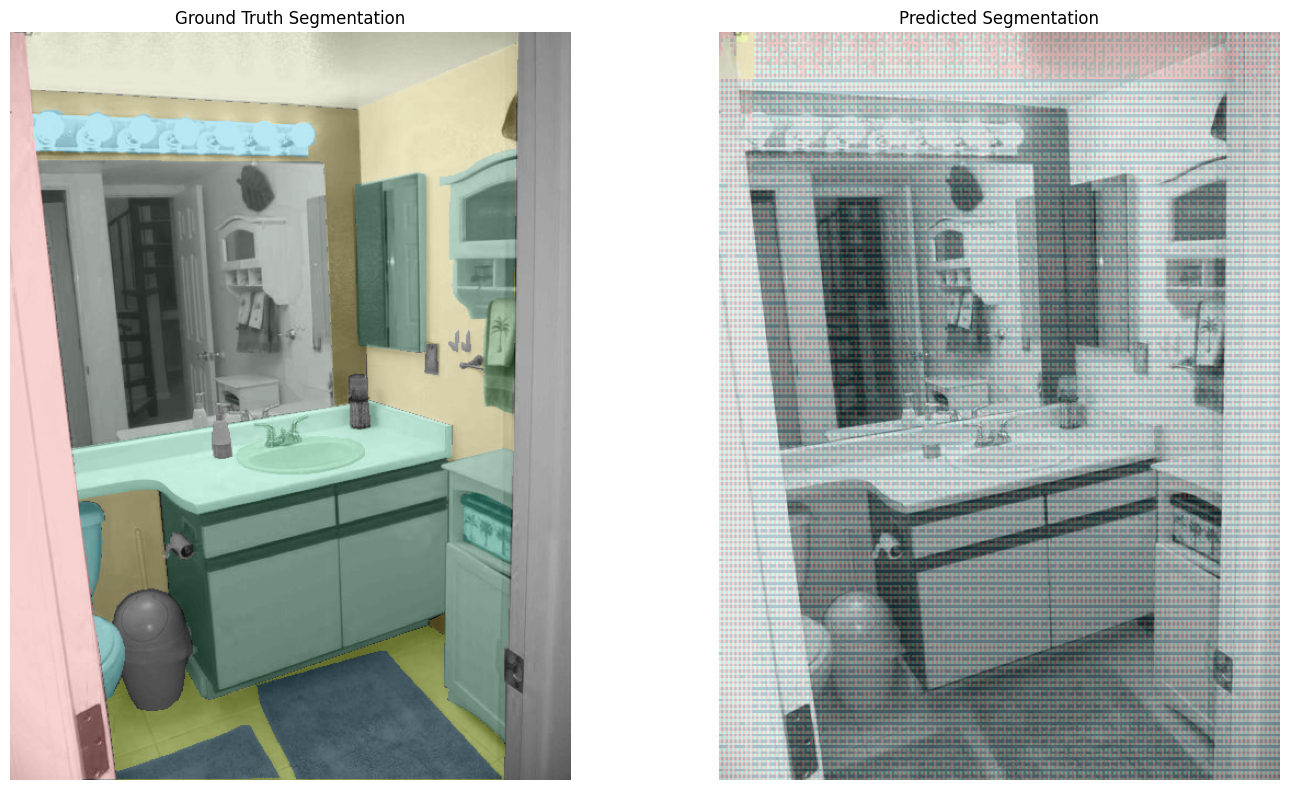

Max Logit: 383.22808837890625
Min Logit: -218.4866180419922
Mean Logit: 6.1578264236450195


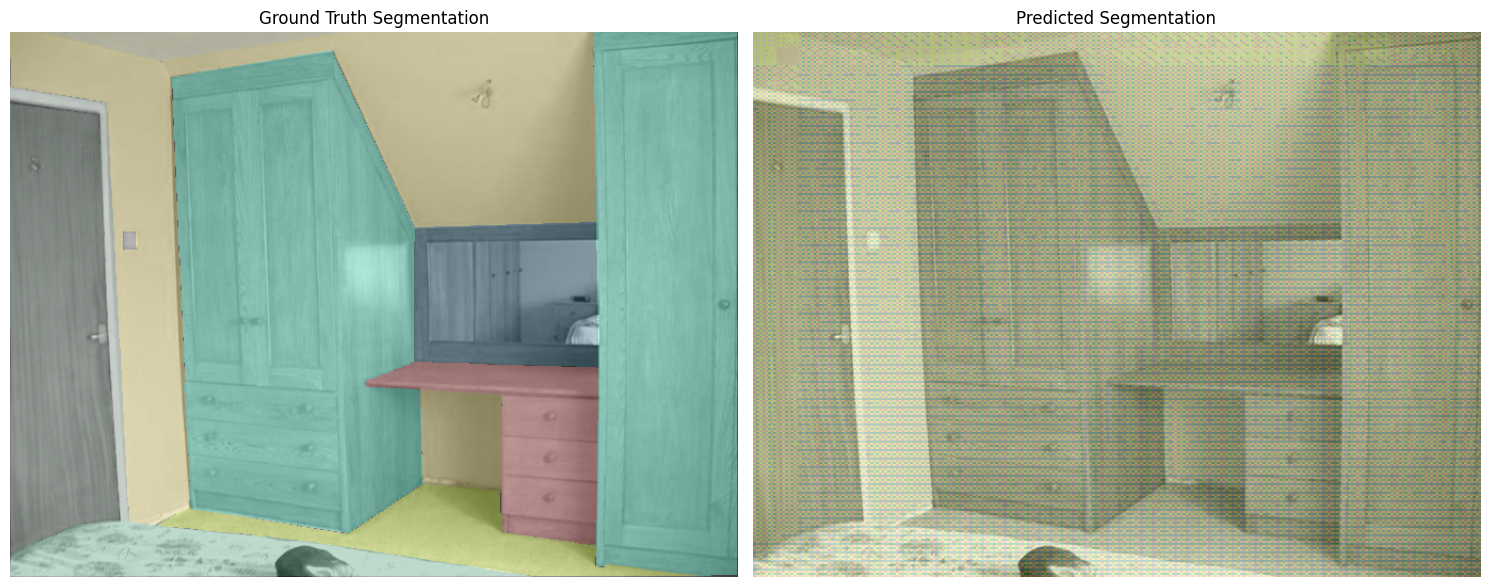

Max Logit: 311.25250244140625
Min Logit: -175.1867218017578
Mean Logit: 5.776800632476807


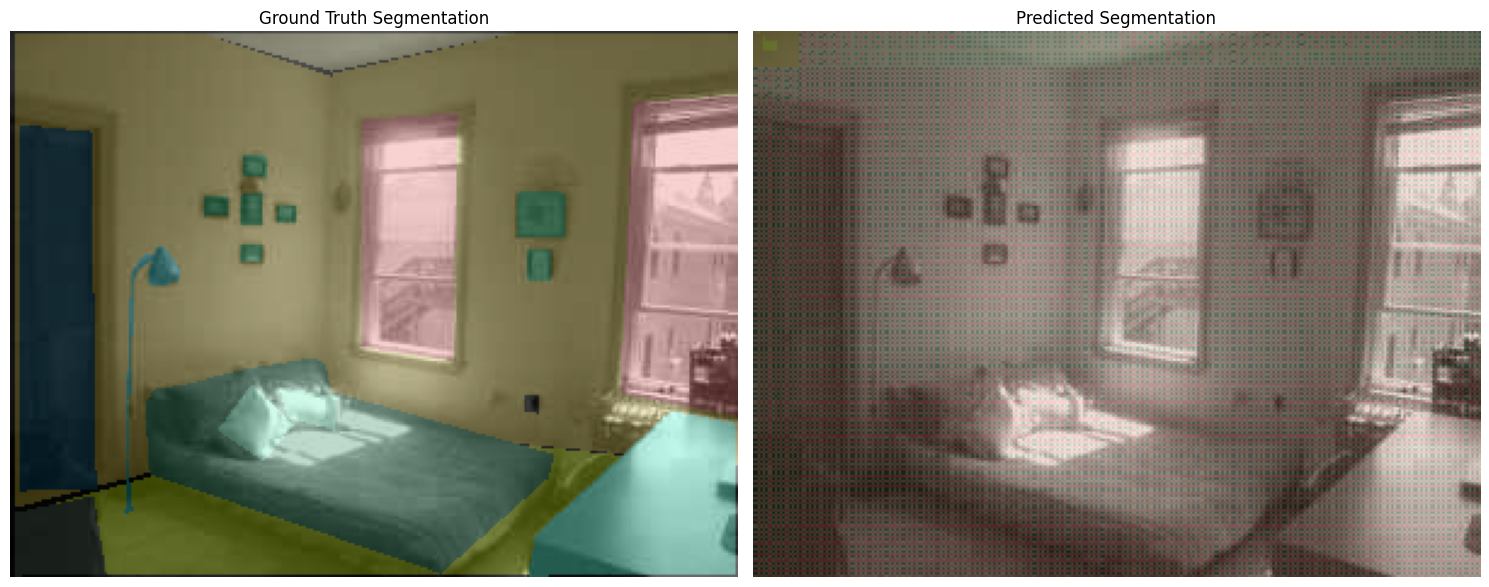

Max Logit: 291.11114501953125
Min Logit: -164.1915283203125
Mean Logit: 5.866590976715088


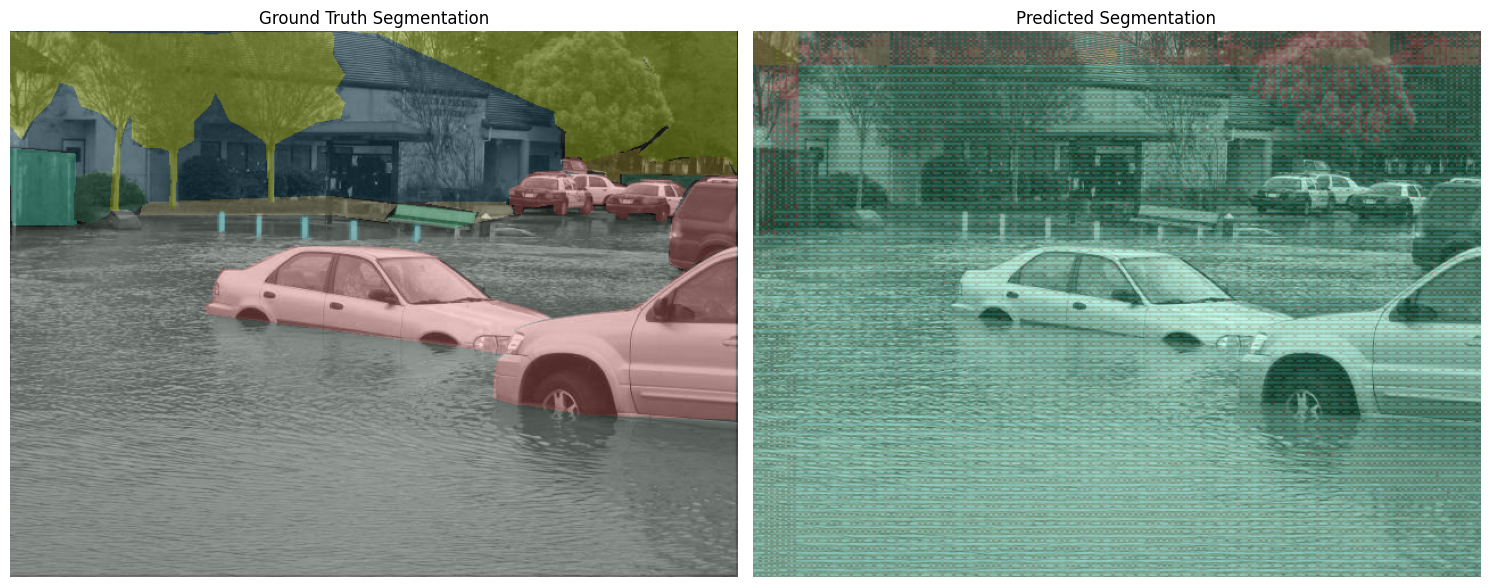

In [17]:
color_pallete = np.random.random((150, 3))

import random
for idx in list(range(5)):
    path_to_image = os.path.join(test_data.path_to_images, test_roots[idx]+".jpg")
    path_to_annotation = os.path.join(test_data.path_to_annotations, test_roots[idx]+".png")

    inference_image(model, path_to_image, path_to_annotation, color_pallete)